# EEG Processing (BCICIV 2a) — Pipeline **sem vazamento de dados**

Este notebook foi reescrito para evitar **data leakage**, especialmente em:
- normalização/standardização (fit **somente no treino de cada fold**), e
- avaliação **LOSO (Leave-One-Subject-Out)**.

> Se você quiser comparar CNN vs CSP-LDA, encaixe o treino **dentro** do loop do LOSO (Cell “LOSO split + normalização segura”).


In [1]:
# ============================================================================
# 0) Imports + Painel de controle
# ============================================================================
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import LeaveOneGroupOut

# ----------------------------
# Diretórios
# ----------------------------
# Tenta encontrar o diretório de dados de forma robusta
def find_data_dir():
    """Localiza data/raw/patients a partir do diretório atual ou parentes."""
    candidates = [
        Path("data/raw/patients"),           # a partir da raiz do projeto
        Path("../data/raw/patients"),        # a partir do diretório notebooks/
        Path(r"C:\Users\Chari\Documents\Obsidian Vault\CNN_vs_CSP\data\raw\patients"),  # caminho absoluto
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    # Se nenhum existir, retorna o primeiro (para erro descritivo)
    return candidates[0]

DATA_DIR = find_data_dir()

if not DATA_DIR.exists():
    print(f"⚠️ Aviso: DATA_DIR não encontrado em: {DATA_DIR}")
    print(f"  Diretório atual: {Path.cwd()}")

FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Dataset / paciente para visualização
# ----------------------------
PATIENT_ID = 1  # usado nas células de visualização (não afeta LOSO)

# ----------------------------
# Sinal
# ----------------------------
SFREQ = 250  # BCICIV 2a é tipicamente 250 Hz
FILTER_LOW = 8
FILTER_HIGH = 30
FILTER_ORDER = 4

# ----------------------------
# Flags (controle)
# ----------------------------
USE_FILTER = True              # filtrar por trial (seguro; não mistura treino/teste)
USE_DATA_NORMALIZATION = True  # normalização segura (aplicada dentro do fold no LOSO)
NORM_STRATEGY = "fold_train_stats"  # "fold_train_stats" (recomendado) | "per_trial"

# Normalização apenas para plot (escala [0,1] por canal) — não muda X do treinamento
USE_PLOT_MINMAX = False

SAVE_FIGURES = True
SHOW_PLOTS = True

# ----------------------------
# Visualização
# ----------------------------
CHANNELS_TO_PLOT = ['EEG-C3', 'EEG-Cz', 'EEG-C4']
NUM_TRIALS_TO_PLOT = 6
FIG_DPI = 300

print("╔═══════════════════════════════════════════════════════╗")
print("║          CONFIGURAÇÕES ATIVAS DO PIPELINE            ║")
print("╠═══════════════════════════════════════════════════════╣")
print(f"║ DATA_DIR: {str(DATA_DIR):.<49}║")
print(f"║ SFREQ: {SFREQ} Hz{'.'*43}║")
print(f"║ Filtro Butterworth: {'✓ ATIVO' if USE_FILTER else '✗ DESATIVADO':.<40}║")
print(f"║ Banda: {FILTER_LOW}-{FILTER_HIGH} Hz (ordem {FILTER_ORDER}){'.'*20}║")
print(f"║ Normalização p/ treino: {'✓ ATIVA' if USE_DATA_NORMALIZATION else '✗ DESATIVADA':.<34}║")
print(f"║ Estratégia de normalização: {NORM_STRATEGY:.<32}║")
print(f"║ Plot min-max [0,1]: {'✓' if USE_PLOT_MINMAX else '✗':.<40}║")
print("╚═══════════════════════════════════════════════════════╝\n")


╔═══════════════════════════════════════════════════════╗
║          CONFIGURAÇÕES ATIVAS DO PIPELINE            ║
╠═══════════════════════════════════════════════════════╣
║ DATA_DIR: C:\Users\Chari\Documents\Obsidian Vault\CNN_vs_CSP\data\raw\patients║
║ SFREQ: 250 Hz...........................................║
║ Filtro Butterworth: ✓ ATIVO.................................║
║ Banda: 8-30 Hz (ordem 4)....................║
║ Normalização p/ treino: ✓ ATIVA...........................║
║ Estratégia de normalização: fold_train_stats................║
║ Plot min-max [0,1]: ✗.......................................║
╚═══════════════════════════════════════════════════════╝



In [2]:
# ============================================================================
# 1) Funções utilitárias (filtro + normalização SEM vazamento)
# ============================================================================
def butter_bandpass_filter(x: np.ndarray, sfreq: float, low: float, high: float, order: int = 4) -> np.ndarray:
    """Bandpass Butterworth (zero-phase) aplicado em 1D."""
    nyq = 0.5 * sfreq
    lowc = low / nyq
    highc = high / nyq
    b, a = signal.butter(order, [lowc, highc], btype="bandpass")
    return signal.filtfilt(b, a, x)

def zscore_per_trial(X: np.ndarray) -> np.ndarray:
    """Z-score por trial e por canal (sem usar info de outros trials). X: (n_trials,n_times,n_ch)."""
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-8
    return (X - mu) / sd

def fit_channel_stats(X_train: np.ndarray):
    """Estatísticas por canal *apenas do treino do fold*."""
    flat = X_train.reshape(-1, X_train.shape[-1])  # (n_trials*n_times, n_ch)
    mu = flat.mean(axis=0)
    sd = flat.std(axis=0) + 1e-8
    return mu, sd

def apply_channel_stats(X: np.ndarray, mu: np.ndarray, sd: np.ndarray) -> np.ndarray:
    return (X - mu[None, None, :]) / sd[None, None, :]

def load_patient_csv(patient_id: int, data_dir: Path) -> pd.DataFrame:
    fp = data_dir / f"BCICIV_2a_{patient_id}.csv"
    if not fp.exists():
        raise FileNotFoundError(f"Não achei: {fp}")
    df = pd.read_csv(fp)
    # garantias básicas
    if "time" in df.columns:
        df["time"] = df["time"].astype(float)
    return df

def patient_trials_from_df(df: pd.DataFrame, *, apply_filter: bool, sfreq: float,
                           f_low: float, f_high: float, f_order: int) -> tuple[np.ndarray, np.ndarray, list[str]]:
    """Retorna (X_raw, y, eeg_cols) para um paciente.
    - Filtra por labels 'left'/'right'
    - Agrupa por epoch (trial)
    - X_raw tem shape (n_trials, n_times, n_ch) e NÃO é normalizado aqui.
    """
    df = df[df["label"].isin(["left", "right"])].copy()
    if df.empty:
        return np.empty((0,0,0)), np.empty((0,)), []

    df = df.sort_values("time").reset_index(drop=True)
    eeg_cols = [c for c in df.columns if c.startswith("EEG-")]
    if not eeg_cols:
        raise ValueError("Não encontrei colunas EEG-*")
    if "epoch" not in df.columns:
        raise ValueError("Não encontrei coluna 'epoch'")

    X_list=[]
    y_list=[]
    # processa cada epoch separadamente (seguro)
    for epoch_id in df["epoch"].unique():
        trial = df[df["epoch"] == epoch_id].sort_values("time")
        if len(trial) == 0:
            continue
        label = trial["label"].iloc[0]
        y = 0 if label == "left" else 1

        sigs=[]
        for col in eeg_cols:
            x = trial[col].to_numpy()
            if apply_filter:
                x = butter_bandpass_filter(x, sfreq, f_low, f_high, order=f_order)
            sigs.append(x)
        X = np.stack(sigs, axis=-1)  # (n_times, n_ch)
        X_list.append(X)
        y_list.append(y)

    # garante shape consistente
    # se tiverem tamanhos diferentes, trunca para o mínimo (evita erro silencioso)
    n_times = min(x.shape[0] for x in X_list) if X_list else 0
    X_list = [x[:n_times, :] for x in X_list]
    X_arr = np.stack(X_list, axis=0) if X_list else np.empty((0,0,0))
    y_arr = np.asarray(y_list, dtype=int)

    return X_arr, y_arr, eeg_cols


In [3]:
# ============================================================================
# 2) Carregar 1 paciente (visualização)
# ============================================================================
df_p = load_patient_csv(PATIENT_ID, DATA_DIR)
X_p_raw, y_p, eeg_columns = patient_trials_from_df(
    df_p,
    apply_filter=USE_FILTER,
    sfreq=SFREQ,
    f_low=FILTER_LOW,
    f_high=FILTER_HIGH,
    f_order=FILTER_ORDER,
)

print(f"✓ Paciente {PATIENT_ID}: {X_p_raw.shape[0]} trials, {X_p_raw.shape[1]} amostras/trial, {X_p_raw.shape[2]} canais")
print(f"✓ Labels: left={int((y_p==0).sum())} | right={int((y_p==1).sum())}")
print(f"✓ Exemplos de canais: {eeg_columns[:8]}{'...' if len(eeg_columns)>8 else ''}") 


✓ Paciente 1: 144 trials, 201 amostras/trial, 22 canais
✓ Labels: left=72 | right=72
✓ Exemplos de canais: ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3']...


In [4]:
# ============================================================================
# 3) Preparar dados p/ plot (normalização segura por trial, opcional)
# ============================================================================
# Para visualização, é OK fazer z-score por trial (não usa info de outros sujeitos/folds)
X_p_plot = X_p_raw.copy()

if USE_DATA_NORMALIZATION:
    # aqui usamos PER-TRIAL (visualização) para não “misturar” trials
    X_p_plot = zscore_per_trial(X_p_plot)

# mean/std por classe
X_left = X_p_plot[y_p==0]
X_right = X_p_plot[y_p==1]

mean_left = X_left.mean(axis=0) if len(X_left) else None      # (n_times, n_ch)
std_left  = X_left.std(axis=0)  if len(X_left) else None
mean_right = X_right.mean(axis=0) if len(X_right) else None
std_right  = X_right.std(axis=0)  if len(X_right) else None

print("✓ Preparado para plot: mean/std calculados por classe")


✓ Preparado para plot: mean/std calculados por classe


✓ Salvo: figures\trials_mean_comparison.png


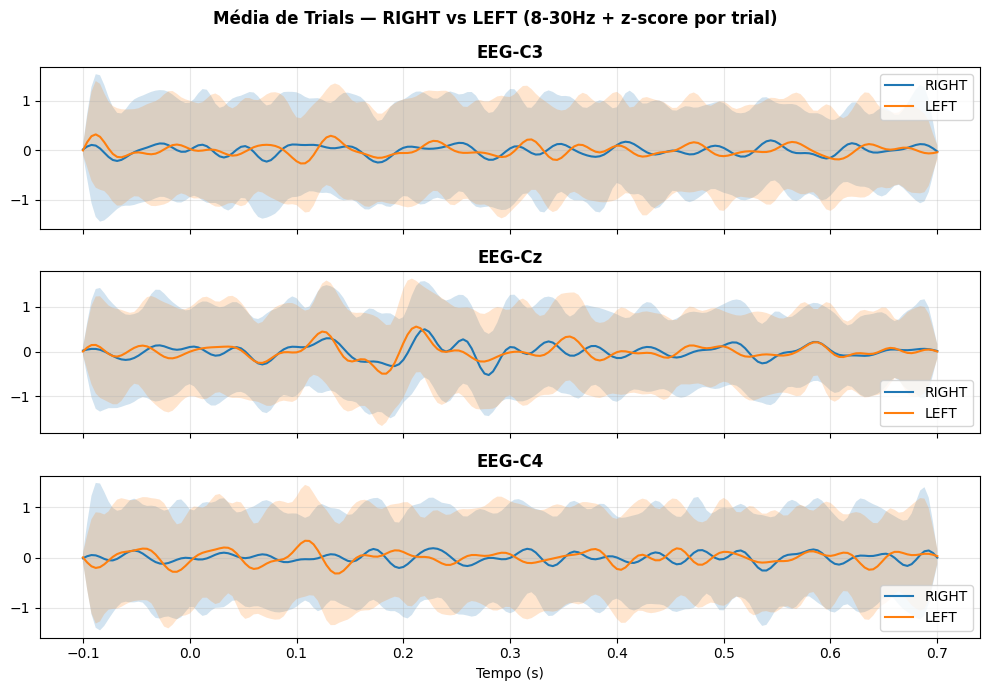

In [5]:
# ============================================================================
# 4) Plot: médias RIGHT vs LEFT (C3/Cz/C4 por padrão)
# ============================================================================
time_axis = np.linspace(-0.1, 0.7, X_p_plot.shape[1])

channels_to_plot = CHANNELS_TO_PLOT
missing = [c for c in channels_to_plot if c not in eeg_columns]
if missing:
    raise ValueError(f"Canais não encontrados no CSV: {missing}")

fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(10, 7), sharex=True)

title_bits=[]
if USE_FILTER: title_bits.append(f"{FILTER_LOW}-{FILTER_HIGH}Hz")
if USE_DATA_NORMALIZATION: title_bits.append("z-score por trial")
title = " + ".join(title_bits) if title_bits else "original"

fig.suptitle(f"Média de Trials — RIGHT vs LEFT ({title})", fontsize=12, fontweight='bold')

for i, ch in enumerate(channels_to_plot):
    ch_idx = eeg_columns.index(ch)
    ax = axes[i]

    if mean_right is not None:
        ax.plot(time_axis, mean_right[:, ch_idx], label="RIGHT")
        ax.fill_between(time_axis,
                        mean_right[:, ch_idx] - std_right[:, ch_idx],
                        mean_right[:, ch_idx] + std_right[:, ch_idx],
                        alpha=0.2)
    if mean_left is not None:
        ax.plot(time_axis, mean_left[:, ch_idx], label="LEFT")
        ax.fill_between(time_axis,
                        mean_left[:, ch_idx] - std_left[:, ch_idx],
                        mean_left[:, ch_idx] + std_left[:, ch_idx],
                        alpha=0.2)

    ax.set_title(ch, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Tempo (s)")
plt.tight_layout()

if SAVE_FIGURES:
    out = FIGURES_DIR / "trials_mean_comparison.png"
    plt.savefig(out, dpi=FIG_DPI, bbox_inches='tight')
    print(f"✓ Salvo: {out}")

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


✓ Salvo: figures\trials_left.png


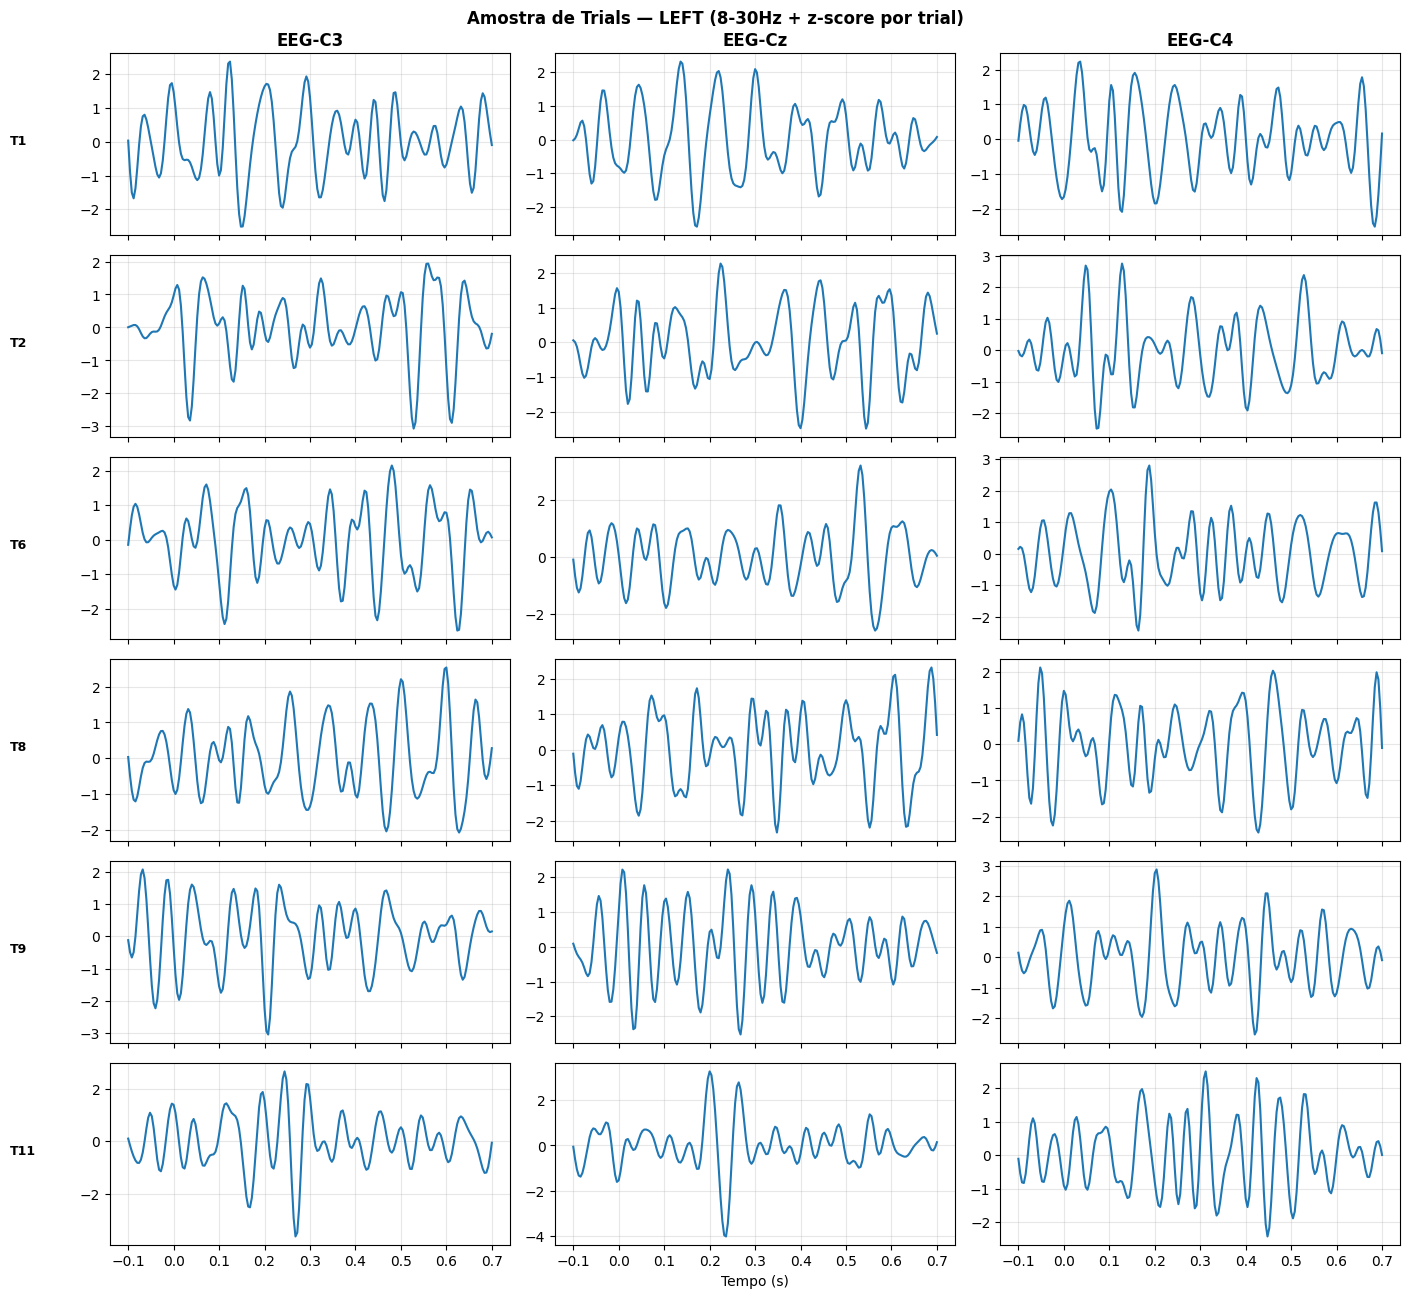

✓ Salvo: figures\trials_right.png


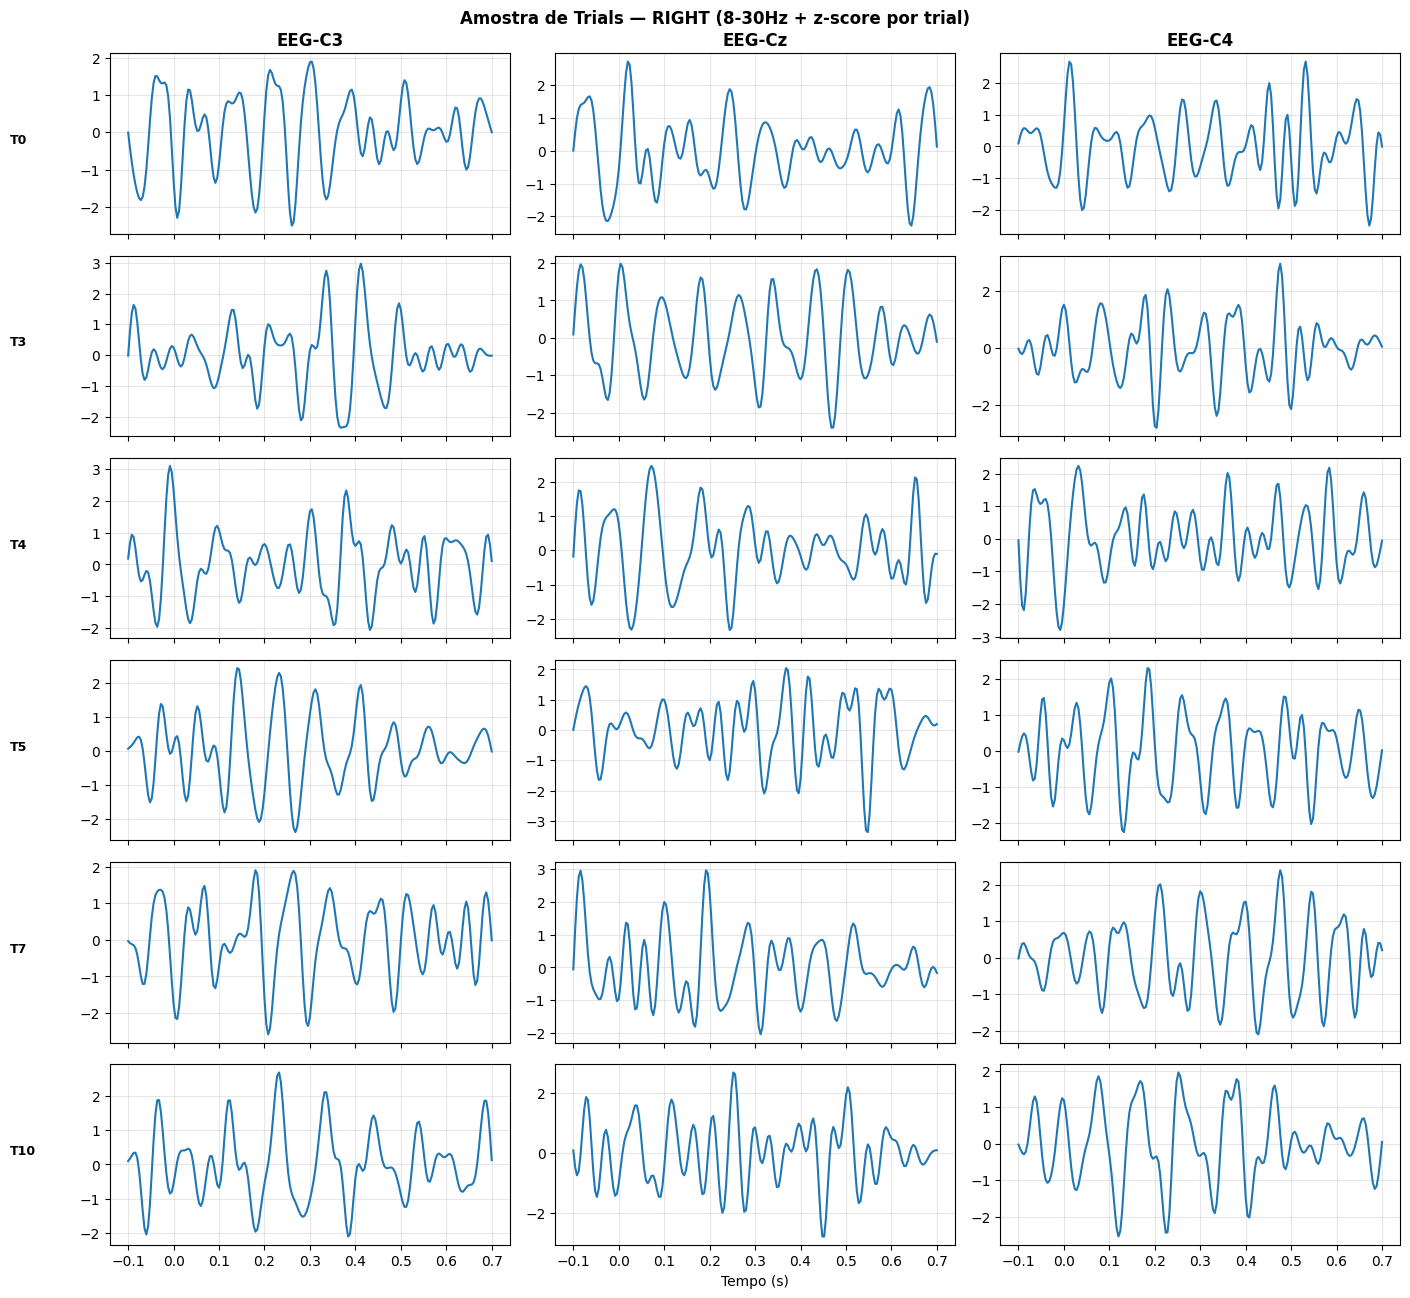

In [6]:
# ============================================================================
# 5) Plot: amostra de trials (LEFT e RIGHT)
# ============================================================================
def plot_sample_trials(X_plot, y, label_value: int, eeg_cols, channels_to_plot, num_trials: int, fname: str):
    trials_idx = np.where(y == label_value)[0]
    if len(trials_idx) == 0:
        print("(sem trials para este label)")
        return

    take = trials_idx[:min(num_trials, len(trials_idx))]
    fig, axes = plt.subplots(len(take), len(channels_to_plot), figsize=(14, 2.2*len(take)), sharex=True)

    if len(take) == 1:
        axes = np.expand_dims(axes, axis=0)
    if len(channels_to_plot) == 1:
        axes = np.expand_dims(axes, axis=1)

    label_name = "LEFT" if label_value == 0 else "RIGHT"
    title_bits=[]
    if USE_FILTER: title_bits.append(f"{FILTER_LOW}-{FILTER_HIGH}Hz")
    if USE_DATA_NORMALIZATION: title_bits.append("z-score por trial")
    title = " + ".join(title_bits) if title_bits else "original"

    fig.suptitle(f"Amostra de Trials — {label_name} ({title})", fontsize=12, fontweight='bold')

    t = np.linspace(-0.1, 0.7, X_plot.shape[1])

    for r, trial_i in enumerate(take):
        for c, ch in enumerate(channels_to_plot):
            ax = axes[r, c]
            ch_idx = eeg_cols.index(ch)
            ax.plot(t, X_plot[trial_i, :, ch_idx])
            ax.grid(True, alpha=0.3)
            if r == 0:
                ax.set_title(ch, fontweight='bold')
            if c == 0:
                ax.text(-0.25, 0.5, f"T{trial_i}", transform=ax.transAxes, fontsize=9, fontweight='bold')

    axes[-1, max(0, len(channels_to_plot)//2)].set_xlabel("Tempo (s)")
    plt.tight_layout()

    if SAVE_FIGURES:
        out = FIGURES_DIR / fname
        plt.savefig(out, dpi=FIG_DPI, bbox_inches='tight')
        print(f"✓ Salvo: {out}")

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()

X_p_plot_for_trials = X_p_plot  # já está filtrado e (se habilitado) z-score por trial

plot_sample_trials(X_p_plot_for_trials, y_p, 0, eeg_columns, CHANNELS_TO_PLOT, NUM_TRIALS_TO_PLOT, "trials_left.png")
plot_sample_trials(X_p_plot_for_trials, y_p, 1, eeg_columns, CHANNELS_TO_PLOT, NUM_TRIALS_TO_PLOT, "trials_right.png")


In [7]:
# ============================================================================
# 6) Carregar dataset completo (todos os pacientes) — para LOSO
# ============================================================================
print("📦 Carregando dataset completo...")

# tenta descobrir pacientes disponíveis (BCICIV_2a_1.csv ... BCICIV_2a_9.csv)
available=[]
for pid in range(1, 10):
    if (DATA_DIR / f"BCICIV_2a_{pid}.csv").exists():
        available.append(pid)

if not available:
    raise FileNotFoundError(f"Não encontrei arquivos BCICIV_2a_*.csv em {DATA_DIR.resolve()}")

X_all=[]
y_all=[]
groups_all=[]
eeg_cols_ref=None

for pid in available:
    df = load_patient_csv(pid, DATA_DIR)
    X_pid, y_pid, eeg_cols = patient_trials_from_df(
        df,
        apply_filter=USE_FILTER,  # filtro por trial (seguro)
        sfreq=SFREQ,
        f_low=FILTER_LOW,
        f_high=FILTER_HIGH,
        f_order=FILTER_ORDER,
    )
    if X_pid.size == 0:
        continue

    if eeg_cols_ref is None:
        eeg_cols_ref = eeg_cols
    else:
        # garante mesma ordem/mesmo set de canais
        if eeg_cols != eeg_cols_ref:
            raise ValueError(f"Colunas EEG diferentes entre pacientes. Ex.: paciente {pid} != referência")

    # ⚠️ NÃO trunca aqui! A truncagem será feita dentro do LOSO (por fold)
    X_all.append(X_pid)
    y_all.append(y_pid)
    groups_all.append(np.full(len(y_pid), pid, dtype=int))

# concat SEM truncagem global
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)
groups = np.concatenate(groups_all, axis=0)

print(f"✓ Pacientes: {available}")
print(f"✓ X: {X.shape} (n_trials, n_times, n_ch) — ainda não truncado!")
print(f"✓ y: {y.shape} | left={(y==0).sum()} right={(y==1).sum()}")
print(f"✓ groups: {groups.shape} | únicos={np.unique(groups)}")


📦 Carregando dataset completo...
✓ Pacientes: [1, 2, 3, 4, 5, 6, 7, 8, 9]
✓ X: (1296, 201, 22) (n_trials, n_times, n_ch) — ainda não truncado!
✓ y: (1296,) | left=648 right=648
✓ groups: (1296,) | únicos=[1 2 3 4 5 6 7 8 9]


In [8]:
# ============================================================================
# 7) LOSO split + normalização segura (SEM vazamento de min_times)
# ============================================================================
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

loso = LeaveOneGroupOut()

def normalize_fold(X_train, X_test):
    if not USE_DATA_NORMALIZATION:
        return X_train, X_test

    if NORM_STRATEGY == "per_trial":
        return zscore_per_trial(X_train), zscore_per_trial(X_test)

    if NORM_STRATEGY == "fold_train_stats":
        mu, sd = fit_channel_stats(X_train)   # <-- FIT SOMENTE NO TREINO (seguro)
        return apply_channel_stats(X_train, mu, sd), apply_channel_stats(X_test, mu, sd)

    raise ValueError(f"NORM_STRATEGY desconhecida: {NORM_STRATEGY}")

print("✂️ LOSO iniciando — rodando CSP+LDA para cada fold...\n")

# Inicializar dicionário para armazenar resultados ANTES do loop
results_csp_lda = {}

for fold_idx, (train_index, test_index) in enumerate(loso.split(X, y, groups=groups), start=1):
    test_subject = int(np.unique(groups[test_index])[0])

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # normalização SEM vazamento
    X_train_n, X_test_n = normalize_fold(X_train, X_test)

    print(f"Fold {fold_idx}: TESTE no paciente {test_subject} | train={len(train_index)} test={len(test_index)}")
    print(f"   X_train_n={X_train_n.shape} | X_test_n={X_test_n.shape}")

    # ========================================================================
    # BLOCO: CSP + LDA (DENTRO DO LOOP DO LOSO)
    # ========================================================================
    
    # --- 1. Preparação dos Dados para MNE ---
    # O MNE espera o formato (n_epochs, n_channels, n_times).
    if X_train_n.shape[-1] < X_train_n.shape[1]: 
        # Assume que a última dimensão é canais e a penúltima é tempo
        X_train_mne = X_train_n.transpose(0, 2, 1)
        X_test_mne  = X_test_n.transpose(0, 2, 1)
    else:
        X_train_mne = X_train_n
        X_test_mne  = X_test_n

    # Garante que os labels correspondam aos índices do fold atual
    y_train_fold = y[train_index]
    y_test_fold  = y[test_index]

    # --- 1.5 Validação de dados ---
    print(f"   DEBUG: X_train_mne shape={X_train_mne.shape}, X_test_mne shape={X_test_mne.shape}")
    print(f"   DEBUG: n_trials_train={len(y_train_fold)}, n_channels={X_train_mne.shape[1]}")
    print(f"   DEBUG: Contains NaN/Inf in train? {np.isnan(X_train_mne).any() or np.isinf(X_train_mne).any()}")

    # --- 2. CSP (Common Spatial Patterns) ---
    csp = CSP(n_components=min(8, X_train_mne.shape[1]-1), reg='shrunk', log=True, norm_trace=True)

    # Fit e Transform no Treino
    X_train_feats = csp.fit_transform(X_train_mne, y_train_fold)

    # Transform no Teste (usando os filtros aprendidos no treino)
    X_test_feats  = csp.transform(X_test_mne)

    # --- 3. Classificador LDA ---
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_feats, y_train_fold)
    y_pred = lda.predict(X_test_feats)

    # --- 4. Métricas ---
    acc = accuracy_score(y_test_fold, y_pred)
    kappa = cohen_kappa_score(y_test_fold, y_pred)
    cm = confusion_matrix(y_test_fold, y_pred)

    # --- 5. Salvar Resultados ---
    results_csp_lda[test_subject] = {
        'acc': acc,
        'kappa': kappa,
        'confusion': cm,
        'y_true': y_test_fold,
        'y_pred': y_pred
    }

    print(f"   [CSP+LDA] Sujeito {test_subject}: Acc={acc:.4f}, Kappa={kappa:.4f}\n")

✂️ LOSO iniciando — rodando CSP+LDA para cada fold...

Fold 1: TESTE no paciente 1 | train=1152 test=144
   X_train_n=(1152, 201, 22) | X_test_n=(144, 201, 22)
   DEBUG: X_train_mne shape=(1152, 22, 201), X_test_mne shape=(144, 22, 201)
   DEBUG: n_trials_train=1152, n_channels=22
   DEBUG: Contains NaN/Inf in train? False
Computing rank from data with rank=None
    Using tolerance 7 (2.2e-16 eps * 22 dim * 1.4e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using SHRUNK
Done.
Estimating class=1 covariance using SHRUNK
Done.
   [CSP+LDA] Sujeito 1: Acc=0.6319, Kappa=0.2639

Fold 2: TESTE no paciente 2 | train=1152 test=144
   X_train_n=(1152, 201, 22) | X_test_n=(144, 201, 22)
   DEBUG: X_train_mne shape=(1152, 22, 201), X_test_mne shape=(144, 22, 201)
   DEBUG: n_trials_train=1152, n_channels=22
   DEBUG: Contains NaN/Inf in train? False
Computing ra

In [9]:
# ==============================================================================
# BLOCO PÓS-LOOP: Análise dos Resultados Globais (CSP+LDA)
# ==============================================================================
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("RESUMO FINAL: CSP + LDA (Leave-One-Subject-Out)")
print("="*60)

# 1. Extrair métricas do dicionário
acc_list = [res['acc'] for res in results_csp_lda.values()]
kappa_list = [res['kappa'] for res in results_csp_lda.values()]
subjects = list(results_csp_lda.keys())

# 2. Criar DataFrame para visualização tabular
df_results = pd.DataFrame({
    'Subject': subjects,
    'Accuracy': acc_list,
    'Kappa': kappa_list
})

# 3. Estatísticas Descritivas
mean_acc = np.mean(acc_list)
std_acc = np.std(acc_list)
mean_kappa = np.mean(kappa_list)
std_kappa = np.std(kappa_list)

print(df_results.round(4))
print("-" * 60)
print(f"MÉDIA GLOBAL: Acc = {mean_acc:.4f} (±{std_acc:.4f}) | Kappa = {mean_kappa:.4f} (±{std_kappa:.4f})")
print("-" * 60)

# (Opcional) Salvar em CSV para usar no artigo depois
df_results.to_csv('resultados_csp_lda.csv', index=False)
print("Resultados salvos em 'resultados_csp_lda.csv'.")


RESUMO FINAL: CSP + LDA (Leave-One-Subject-Out)
   Subject  Accuracy   Kappa
0        1    0.6319  0.2639
1        2    0.5486  0.0972
2        3    0.6042  0.2083
3        4    0.5208  0.0417
4        5    0.5208  0.0417
5        6    0.5556  0.1111
6        7    0.6042  0.2083
7        8    0.7014  0.4028
8        9    0.7639  0.5278
------------------------------------------------------------
MÉDIA GLOBAL: Acc = 0.6057 (±0.0782) | Kappa = 0.2114 (±0.1564)
------------------------------------------------------------
Resultados salvos em 'resultados_csp_lda.csv'.


In [11]:
# ============================================================================
# 8) Preparação para EEGNet — Imports + Hparams
# ============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import random

# Configuração de seeding para reprodutibilidade
def set_seed(seed):
    """Fixa seed para NumPy, TensorFlow e Python."""
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    # Para GPU (se houver)
    tf.config.experimental.enable_op_determinism()

# ----------------------------
# Hparams EEGNet (fixos)
# ----------------------------
EEGNET_HPARAMS = {
    'F1': 8,                 # Número de spatial filters (Depth-wise)
    'F2': 16,                # Número de point-wise filters
    'D': 2,                  # Multiplicador de profundidade (depth-wise)
    'kernel_length': 64,     # Comprimento do kernel temporal (primeira layer)
    'dropout_rate': 0.5,
    'learning_rate': 0.001,
    'epochs': 100,
    'batch_size': 16,
    'early_stopping_patience': 15,
}

# Seeds para múltiplas rodadas
EEGNET_SEEDS = [42, 123, 456]  # Mínimo 3 seeds

print("╔═══════════════════════════════════════════════════════╗")
print("║         CONFIGURAÇÕES EEGNET (FIXAS)                 ║")
print("╠═══════════════════════════════════════════════════════╣")
print(f"║ F1 (spatial): {EEGNET_HPARAMS['F1']:.<48}║")
print(f"║ F2 (point-wise): {EEGNET_HPARAMS['F2']:.<45}║")
print(f"║ D (depth multiplier): {EEGNET_HPARAMS['D']:.<40}║")
print(f"║ Kernel temporal: {EEGNET_HPARAMS['kernel_length']:.<46}║")
print(f"║ Dropout: {EEGNET_HPARAMS['dropout_rate']:.<49}║")
print(f"║ Learning Rate: {EEGNET_HPARAMS['learning_rate']:.<46}║")
print(f"║ Batch Size: {EEGNET_HPARAMS['batch_size']:.<46}║")
print(f"║ Seeds: {str(EEGNET_SEEDS):.<48}║")
print("╚═══════════════════════════════════════════════════════╝\n")


╔═══════════════════════════════════════════════════════╗
║         CONFIGURAÇÕES EEGNET (FIXAS)                 ║
╠═══════════════════════════════════════════════════════╣
║ F1 (spatial): 8...............................................║
║ F2 (point-wise): 16...........................................║
║ D (depth multiplier): 2.......................................║
║ Kernel temporal: 64............................................║
║ Dropout: 0.5..............................................║
║ Learning Rate: 0.001.........................................║
║ Batch Size: 16............................................║
║ Seeds: [42, 123, 456]..................................║
╚═══════════════════════════════════════════════════════╝



c:\Users\Chari\Documents\Obsidian Vault\CNN_vs_CSP\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [19]:
# ============================================================================
# 9) Arquitetura EEGNet (Compact Form)
# ============================================================================
def build_eegnet(n_channels, n_times, n_classes=2, **hparams):
    """
    Constrói modelo EEGNet conforme Lawhern et al. (2018).
    
    Entrada: (n_trials, n_channels, n_times) 
    Internamente convertida para: (n_trials, n_times, n_channels, 1) — channels_last format
    Saída: probabilidade (batch_size, n_classes)
    """
    F1 = hparams.get('F1', 8)
    F2 = hparams.get('F2', 16)
    D = hparams.get('D', 2)
    kernel_length = hparams.get('kernel_length', 64)
    dropout_rate = hparams.get('dropout_rate', 0.5)
    
    # Input: (n_channels, n_times)
    input_shape = (n_channels, n_times)
    
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Transpor de (n_ch, n_times) para (n_times, n_ch) + adicionar dimensão
        # Usa Lambda para flexibilidade
        layers.Lambda(lambda x: tf.transpose(x, [0, 2, 1])[:, :, :, tf.newaxis]),
        # Resultado: (batch, n_times, n_ch, 1)
        
        # =========================================================================
        # Block 1: Temporal Convolution + Depth-wise
        # =========================================================================
        layers.Conv2D(F1, (1, kernel_length), padding='same', use_bias=False, 
                      data_format='channels_last',
                      name='conv_temporal'),
        layers.BatchNormalization(name='bn_1'),
        
        # Depth-wise Conv
        layers.DepthwiseConv2D((1, 1), depth_multiplier=D, 
                               padding='valid', use_bias=False,
                               data_format='channels_last',
                               name='depthwise_spatial'),
        layers.BatchNormalization(name='bn_2'),
        layers.Activation('elu'),
        layers.AveragePooling2D((1, 2), data_format='channels_last'),
        layers.Dropout(dropout_rate),
        
        # =========================================================================
        # Block 2: Separable Convolution
        # =========================================================================
        layers.SeparableConv2D(F2, (1, 16), padding='same', use_bias=False,
                               data_format='channels_last',
                               name='sep_conv'),
        layers.BatchNormalization(name='bn_3'),
        layers.Activation('elu'),
        layers.AveragePooling2D((1, 2), data_format='channels_last'),
        layers.Dropout(dropout_rate),
        
        # =========================================================================
        # Classificação
        # =========================================================================
        layers.Flatten(),
        layers.Dense(n_classes, activation='softmax', name='classification')
    ], name='EEGNet_Compact')
    
    return model

print("✓ Função build_eegnet() definida")
print("  - Entrada esperada: (n_epochs, n_channels, n_times)")
print("  - Convertida internamente para: (n_epochs, n_times, n_channels, 1)")
print("  - Saída: probabilidades (batch_size, 2)")

✓ Função build_eegnet() definida
  - Entrada esperada: (n_epochs, n_channels, n_times)
  - Convertida internamente para: (n_epochs, n_times, n_channels, 1)
  - Saída: probabilidades (batch_size, 2)


In [20]:
# ============================================================================
# 10) LOSO loop para EEGNet (com múltiplos seeds)
# ============================================================================

print("🧠 LOSO com EEGNet iniciando — rodando para cada seed...\n")

# Dicionário para armazenar resultados: {seed: {subject: {metrics}}}
results_eegnet_all_seeds = {}

for seed in EEGNET_SEEDS:
    print(f"\n{'='*70}")
    print(f"SEED: {seed}")
    print(f"{'='*70}\n")
    
    set_seed(seed)  # Fix seed antes de cada rodada
    
    results_eegnet_seed = {}
    
    for fold_idx, (train_index, test_index) in enumerate(loso.split(X, y, groups=groups), start=1):
        test_subject = int(np.unique(groups[test_index])[0])
        
        X_train, X_test = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        # Normalização SEM vazamento
        X_train_n, X_test_n = normalize_fold(X_train, X_test)
        
        print(f"Fold {fold_idx}: TESTE no paciente {test_subject} | train={len(train_index)} test={len(test_index)}")
        print(f"   X_train_n={X_train_n.shape} | X_test_n={X_test_n.shape}")
        
        # ====================================================================
        # BLOCO: EEGNet (DENTRO DO LOOP LOSO)
        # ====================================================================
        
        # --- 1. Preparação dos dados para EEGNet ---
        # EEGNet espera: (n_epochs, n_channels, n_times)
        if X_train_n.ndim == 3:
            # Se está em (n_trials, n_times, n_ch), transpõe para (n_trials, n_ch, n_times)
            if X_train_n.shape[-1] < X_train_n.shape[1]:
                X_train_eeg = X_train_n.transpose(0, 2, 1)  # (n_trials, n_ch, n_times)
                X_test_eeg = X_test_n.transpose(0, 2, 1)
            else:
                X_train_eeg = X_train_n
                X_test_eeg = X_test_n
        
        # Conversão para float32 (TensorFlow)
        X_train_eeg = X_train_eeg.astype(np.float32)
        X_test_eeg = X_test_eeg.astype(np.float32)
        y_train_fold = y_train_fold.astype(np.int32)
        y_test_fold = y_test_fold.astype(np.int32)
        
        print(f"   EEGNet input shape (train): {X_train_eeg.shape}")
        
        # --- 2. Build modelo EEGNet ---
        n_channels = X_train_eeg.shape[1]
        n_times = X_train_eeg.shape[2]
        
        model = build_eegnet(n_channels, n_times, n_classes=2, **EEGNET_HPARAMS)
        
        # Compile
        optimizer = keras.optimizers.Adam(learning_rate=EEGNET_HPARAMS['learning_rate'])
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # --- 3. Treinamento com Early Stopping ---
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=EEGNET_HPARAMS['early_stopping_patience'],
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train_eeg, y_train_fold,
            validation_split=0.2,
            epochs=EEGNET_HPARAMS['epochs'],
            batch_size=EEGNET_HPARAMS['batch_size'],
            callbacks=[early_stop],
            verbose=0  # Silencioso para não poluir output
        )
        
        # --- 4. Predição no teste ---
        y_pred_prob = model.predict(X_test_eeg, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        # --- 5. Métricas ---
        acc = accuracy_score(y_test_fold, y_pred)
        kappa = cohen_kappa_score(y_test_fold, y_pred)
        cm = confusion_matrix(y_test_fold, y_pred)
        
        # --- 6. Salvar Resultados ---
        results_eegnet_seed[test_subject] = {
            'acc': acc,
            'kappa': kappa,
            'confusion': cm,
            'y_true': y_test_fold,
            'y_pred': y_pred,
            'epochs_trained': len(history.history['loss']),
        }
        
        print(f"   [EEGNet] Sujeito {test_subject}: Acc={acc:.4f}, Kappa={kappa:.4f}, Epochs={len(history.history['loss'])}\n")
        
        # Liberar memória
        keras.backend.clear_session()
        del model
    
    results_eegnet_all_seeds[seed] = results_eegnet_seed

print("\n✓ EEGNet LOSO concluído para todos os seeds")


🧠 LOSO com EEGNet iniciando — rodando para cada seed...


SEED: 42

Fold 1: TESTE no paciente 1 | train=1152 test=144
   X_train_n=(1152, 201, 22) | X_test_n=(144, 201, 22)
   EEGNet input shape (train): (1152, 22, 201)
   [EEGNet] Sujeito 1: Acc=0.5347, Kappa=0.0694, Epochs=16

Fold 2: TESTE no paciente 2 | train=1152 test=144
   X_train_n=(1152, 201, 22) | X_test_n=(144, 201, 22)
   EEGNet input shape (train): (1152, 22, 201)
   [EEGNet] Sujeito 2: Acc=0.5208, Kappa=0.0417, Epochs=16

Fold 3: TESTE no paciente 3 | train=1152 test=144
   X_train_n=(1152, 201, 22) | X_test_n=(144, 201, 22)
   EEGNet input shape (train): (1152, 22, 201)
   [EEGNet] Sujeito 3: Acc=0.4583, Kappa=-0.0833, Epochs=16

Fold 4: TESTE no paciente 4 | train=1152 test=144
   X_train_n=(1152, 201, 22) | X_test_n=(144, 201, 22)
   EEGNet input shape (train): (1152, 22, 201)
   [EEGNet] Sujeito 4: Acc=0.5208, Kappa=0.0417, Epochs=17

Fold 5: TESTE no paciente 5 | train=1152 test=144
   X_train_n=(1152, 201, 22) | X_

In [21]:
# ============================================================================
# 11) Análise dos Resultados EEGNet (Múltiplos Seeds)
# ============================================================================

print("\n" + "="*70)
print("RESUMO FINAL: EEGNet (Leave-One-Subject-Out, Múltiplos Seeds)")
print("="*70 + "\n")

# --- 1. Consolidar resultados por seed ---
results_by_seed = {}
for seed, results_seed in results_eegnet_all_seeds.items():
    acc_list = [res['acc'] for res in results_seed.values()]
    kappa_list = [res['kappa'] for res in results_seed.values()]
    
    results_by_seed[seed] = {
        'mean_acc': np.mean(acc_list),
        'std_acc': np.std(acc_list),
        'mean_kappa': np.mean(kappa_list),
        'std_kappa': np.std(kappa_list),
        'acc_per_subject': acc_list,
        'kappa_per_subject': kappa_list,
    }

# --- 2. Exibir resultados por seed ---
print("Resultados por Seed:")
print("-" * 70)
for seed, metrics in results_by_seed.items():
    print(f"Seed {seed}:")
    print(f"  Accuracy: {metrics['mean_acc']:.4f} (±{metrics['std_acc']:.4f})")
    print(f"  Kappa:    {metrics['mean_kappa']:.4f} (±{metrics['std_kappa']:.4f})")

# --- 3. Média global sobre todos os seeds ---
all_accs = []
all_kappas = []
for seed, results_seed in results_eegnet_all_seeds.items():
    acc_list = [res['acc'] for res in results_seed.values()]
    kappa_list = [res['kappa'] for res in results_seed.values()]
    all_accs.extend(acc_list)
    all_kappas.extend(kappa_list)

global_mean_acc = np.mean(all_accs)
global_std_acc = np.std(all_accs)
global_mean_kappa = np.mean(all_kappas)
global_std_kappa = np.std(all_kappas)

print("-" * 70)
print("MÉDIA GLOBAL (sobre todos os seeds e sujeitos):")
print(f"  Accuracy: {global_mean_acc:.4f} (±{global_std_acc:.4f})")
print(f"  Kappa:    {global_mean_kappa:.4f} (±{global_std_kappa:.4f})")
print("-" * 70)

# --- 4. Tabela detalhada por sujeito (para melhor visualização) ---
print("\nAccuracy por Sujeito (todos os seeds):")
print("-" * 70)

# Pegar primeira seed para ver a lista de sujeitos
first_seed = EEGNET_SEEDS[0]
subjects_eegnet = sorted(results_eegnet_all_seeds[first_seed].keys())

for subject in subjects_eegnet:
    accs_subject = []
    for seed in EEGNET_SEEDS:
        if subject in results_eegnet_all_seeds[seed]:
            accs_subject.append(results_eegnet_all_seeds[seed][subject]['acc'])
    
    mean_acc_subj = np.mean(accs_subject)
    std_acc_subj = np.std(accs_subject)
    print(f"Subject {subject}: {mean_acc_subj:.4f} (±{std_acc_subj:.4f}) | Seeds: {[f'{a:.4f}' for a in accs_subject]}")

# --- 5. Salvar em CSV (resumo por seed) ---
df_eegnet_seeds = pd.DataFrame([
    {'Seed': seed, 
     'Mean_Accuracy': metrics['mean_acc'], 
     'Std_Accuracy': metrics['std_acc'],
     'Mean_Kappa': metrics['mean_kappa'],
     'Std_Kappa': metrics['std_kappa']}
    for seed, metrics in results_by_seed.items()
])

csv_path_seeds = 'resultados_eegnet_por_seed.csv'
df_eegnet_seeds.to_csv(csv_path_seeds, index=False)
print(f"\n✓ Resultados por seed salvos em: {csv_path_seeds}")

# --- 6. Salvar em CSV (detalhado por sujeito e seed) ---
data_detailed = []
for seed in EEGNET_SEEDS:
    for subject, results in results_eegnet_all_seeds[seed].items():
        data_detailed.append({
            'Seed': seed,
            'Subject': subject,
            'Accuracy': results['acc'],
            'Kappa': results['kappa'],
        })

df_eegnet_detailed = pd.DataFrame(data_detailed)
csv_path_detailed = 'resultados_eegnet_detalhado.csv'
df_eegnet_detailed.to_csv(csv_path_detailed, index=False)
print(f"✓ Resultados detalhados salvos em: {csv_path_detailed}")

# --- 7. Comparação lado-a-lado: CSP+LDA vs EEGNet ---
print("\n" + "="*70)
print("COMPARAÇÃO: CSP+LDA vs EEGNet")
print("="*70)

# CSP+LDA (já temos de antes)
csp_accs = [res['acc'] for res in results_csp_lda.values()]
csp_kappas = [res['kappa'] for res in results_csp_lda.values()]
csp_mean_acc = np.mean(csp_accs)
csp_std_acc = np.std(csp_accs)
csp_mean_kappa = np.mean(csp_kappas)
csp_std_kappa = np.std(csp_kappas)

print(f"\nCSP+LDA (baseline):")
print(f"  Accuracy: {csp_mean_acc:.4f} (±{csp_std_acc:.4f})")
print(f"  Kappa:    {csp_mean_kappa:.4f} (±{csp_std_kappa:.4f})")

print(f"\nEEGNet (CNN, múltiplos seeds):")
print(f"  Accuracy: {global_mean_acc:.4f} (±{global_std_acc:.4f})")
print(f"  Kappa:    {global_mean_kappa:.4f} (±{global_std_kappa:.4f})")

# Delta
delta_acc = global_mean_acc - csp_mean_acc
delta_kappa = global_mean_kappa - csp_mean_kappa
print(f"\nDelta (EEGNet - CSP+LDA):")
print(f"  ΔAccuracy: {delta_acc:+.4f}")
print(f"  ΔKappa:    {delta_kappa:+.4f}")
print("="*70)



RESUMO FINAL: EEGNet (Leave-One-Subject-Out, Múltiplos Seeds)

Resultados por Seed:
----------------------------------------------------------------------
Seed 42:
  Accuracy: 0.5054 (±0.0436)
  Kappa:    0.0108 (±0.0873)
Seed 123:
  Accuracy: 0.4938 (±0.0301)
  Kappa:    -0.0123 (±0.0602)
Seed 456:
  Accuracy: 0.5193 (±0.0270)
  Kappa:    0.0386 (±0.0539)
----------------------------------------------------------------------
MÉDIA GLOBAL (sobre todos os seeds e sujeitos):
  Accuracy: 0.5062 (±0.0359)
  Kappa:    0.0123 (±0.0718)
----------------------------------------------------------------------

Accuracy por Sujeito (todos os seeds):
----------------------------------------------------------------------
Subject 1: 0.5278 (±0.0098) | Seeds: ['0.5347', '0.5139', '0.5347']
Subject 2: 0.5231 (±0.0033) | Seeds: ['0.5208', '0.5208', '0.5278']
Subject 3: 0.5000 (±0.0316) | Seeds: ['0.4583', '0.5069', '0.5347']
Subject 4: 0.5324 (±0.0322) | Seeds: ['0.5208', '0.5000', '0.5764']
Subject 5

✓ Salvo: pipeline_comparison.png


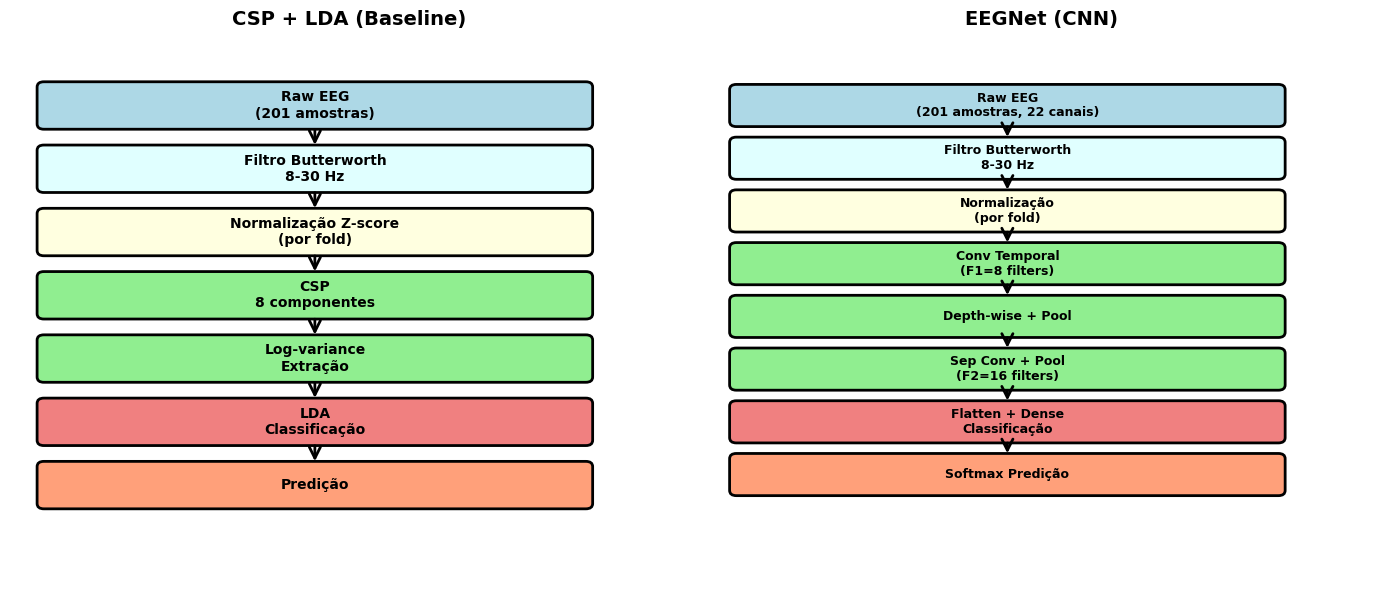

In [22]:
# ============================================================================
# 12) FIGURA 1: Pipeline CSP+LDA vs EEGNet (Comparação esquemática)
# ============================================================================
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, (ax_csp, ax_eeg) = plt.subplots(1, 2, figsize=(14, 6))

# --- CSP+LDA Pipeline ---
ax_csp.set_xlim(0, 10)
ax_csp.set_ylim(0, 10)
ax_csp.axis('off')
ax_csp.set_title('CSP + LDA (Baseline)', fontsize=14, fontweight='bold', pad=20)

y_pos = 9
boxes_csp = [
    ('Raw EEG\n(201 amostras)', 'lightblue'),
    ('Filtro Butterworth\n8-30 Hz', 'lightcyan'),
    ('Normalização Z-score\n(por fold)', 'lightyellow'),
    ('CSP\n8 componentes', 'lightgreen'),
    ('Log-variance\nExtração', 'lightgreen'),
    ('LDA\nClassificação', 'lightcoral'),
    ('Predição', 'lightsalmon'),
]

for i, (label, color) in enumerate(boxes_csp):
    y = y_pos - i * 1.2
    box = FancyBboxPatch((0.5, y-0.35), 8, 0.7, boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor=color, linewidth=2)
    ax_csp.add_patch(box)
    ax_csp.text(4.5, y, label, ha='center', va='center', fontsize=10, fontweight='bold')
    
    if i < len(boxes_csp) - 1:
        arrow = FancyArrowPatch((4.5, y-0.4), (4.5, y-0.8),
                               arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
        ax_csp.add_patch(arrow)

# --- EEGNet Pipeline ---
ax_eeg.set_xlim(0, 10)
ax_eeg.set_ylim(0, 10)
ax_eeg.axis('off')
ax_eeg.set_title('EEGNet (CNN)', fontsize=14, fontweight='bold', pad=20)

y_pos = 9
boxes_eeg = [
    ('Raw EEG\n(201 amostras, 22 canais)', 'lightblue'),
    ('Filtro Butterworth\n8-30 Hz', 'lightcyan'),
    ('Normalização\n(por fold)', 'lightyellow'),
    ('Conv Temporal\n(F1=8 filters)', 'lightgreen'),
    ('Depth-wise + Pool', 'lightgreen'),
    ('Sep Conv + Pool\n(F2=16 filters)', 'lightgreen'),
    ('Flatten + Dense\nClassificação', 'lightcoral'),
    ('Softmax Predição', 'lightsalmon'),
]

for i, (label, color) in enumerate(boxes_eeg):
    y = y_pos - i * 1.0
    box = FancyBboxPatch((0.5, y-0.3), 8, 0.6, boxstyle="round,pad=0.1",
                          edgecolor='black', facecolor=color, linewidth=2)
    ax_eeg.add_patch(box)
    ax_eeg.text(4.5, y, label, ha='center', va='center', fontsize=9, fontweight='bold')
    
    if i < len(boxes_eeg) - 1:
        arrow = FancyArrowPatch((4.5, y-0.35), (4.5, y-0.65),
                               arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
        ax_eeg.add_patch(arrow)

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'pipeline_comparison.png', dpi=FIG_DPI, bbox_inches='tight')
    print("✓ Salvo: pipeline_comparison.png")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


✓ Salvo: eegnet_architecture.png


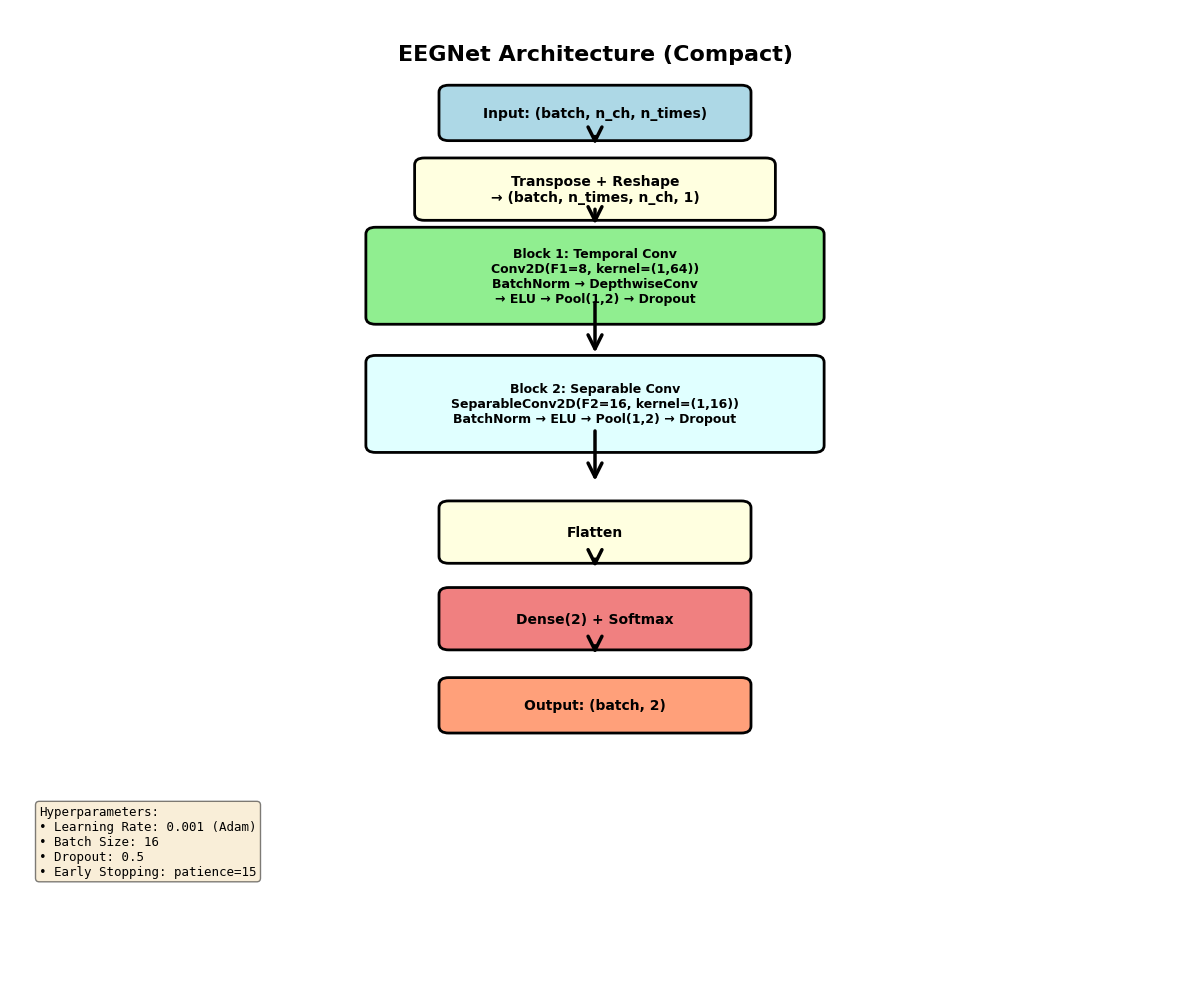

In [23]:
# ============================================================================
# 13) FIGURA 2: Arquitetura EEGNet (Detalhado)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlim(0, 12)
ax.set_ylim(0, 14)
ax.axis('off')

title = "EEGNet Architecture (Compact)"
ax.text(6, 13.5, title, ha='center', va='top', fontsize=16, fontweight='bold')

# Função auxiliar para desenhar blocos
def draw_block(ax, x, y, w, h, label, color='lightblue', fontsize=10):
    box = FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle="round,pad=0.1",
                          edgecolor='black', facecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x, y, label, ha='center', va='center', fontsize=fontsize, 
            fontweight='bold', wrap=True)

def draw_arrow(ax, x1, y1, x2, y2, label=''):
    arrow = FancyArrowPatch((x1, y1), (x2, y2), arrowstyle='->', 
                           mutation_scale=25, linewidth=2.5, color='black')
    ax.add_patch(arrow)
    if label:
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        ax.text(mid_x + 0.5, mid_y, label, ha='left', va='bottom', fontsize=9, style='italic')

# Layer por layer
y = 12.5
draw_block(ax, 6, y, 3, 0.6, 'Input: (batch, n_ch, n_times)', 'lightblue')

y -= 0.8
draw_arrow(ax, 6, 12.2, 6, y+0.3)

y -= 0.3
draw_block(ax, 6, y, 3.5, 0.7, 'Transpose + Reshape\n→ (batch, n_times, n_ch, 1)', 'lightyellow')

y -= 0.9
draw_arrow(ax, 6, y+0.65, 6, y+0.35)

# Block 1
y -= 0.35
draw_block(ax, 6, y, 4.5, 1.2, 
           'Block 1: Temporal Conv\nConv2D(F1=8, kernel=(1,64))\nBatchNorm → DepthwiseConv\n→ ELU → Pool(1,2) → Dropout',
           'lightgreen', fontsize=9)

y -= 1.5
draw_arrow(ax, 6, y+1.15, 6, y+0.35)

# Block 2
y -= 0.35
draw_block(ax, 6, y, 4.5, 1.2,
           'Block 2: Separable Conv\nSeparableConv2D(F2=16, kernel=(1,16))\nBatchNorm → ELU → Pool(1,2) → Dropout',
           'lightcyan', fontsize=9)

y -= 1.5
draw_arrow(ax, 6, y+1.15, 6, y+0.35)

y -= 0.35
draw_block(ax, 6, y, 3, 0.7, 'Flatten', 'lightyellow')

y -= 0.9
draw_arrow(ax, 6, y+0.55, 6, y+0.35)

y -= 0.35
draw_block(ax, 6, y, 3, 0.7, 'Dense(2) + Softmax', 'lightcoral')

y -= 0.9
draw_arrow(ax, 6, y+0.55, 6, y+0.35)

y -= 0.35
draw_block(ax, 6, y, 3, 0.6, 'Output: (batch, 2)', 'lightsalmon', fontsize=10)

# Anotações de hiperparâmetros
note_text = (
    "Hyperparameters:\n"
    "• Learning Rate: 0.001 (Adam)\n"
    "• Batch Size: 16\n"
    "• Dropout: 0.5\n"
    "• Early Stopping: patience=15"
)
ax.text(0.3, 1.5, note_text, fontsize=9, family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'eegnet_architecture.png', dpi=FIG_DPI, bbox_inches='tight')
    print("✓ Salvo: eegnet_architecture.png")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


C:\Users\Chari\AppData\Local\Temp\ipykernel_26128\3786935224.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Method', y='Accuracy', ax=ax, palette='Set2', width=0.6)
C:\Users\Chari\AppData\Local\Temp\ipykernel_26128\3786935224.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_kappa, x='Method', y='Kappa', ax=ax, palette='Set2', width=0.6)


✓ Salvo: metrics_distribution.png


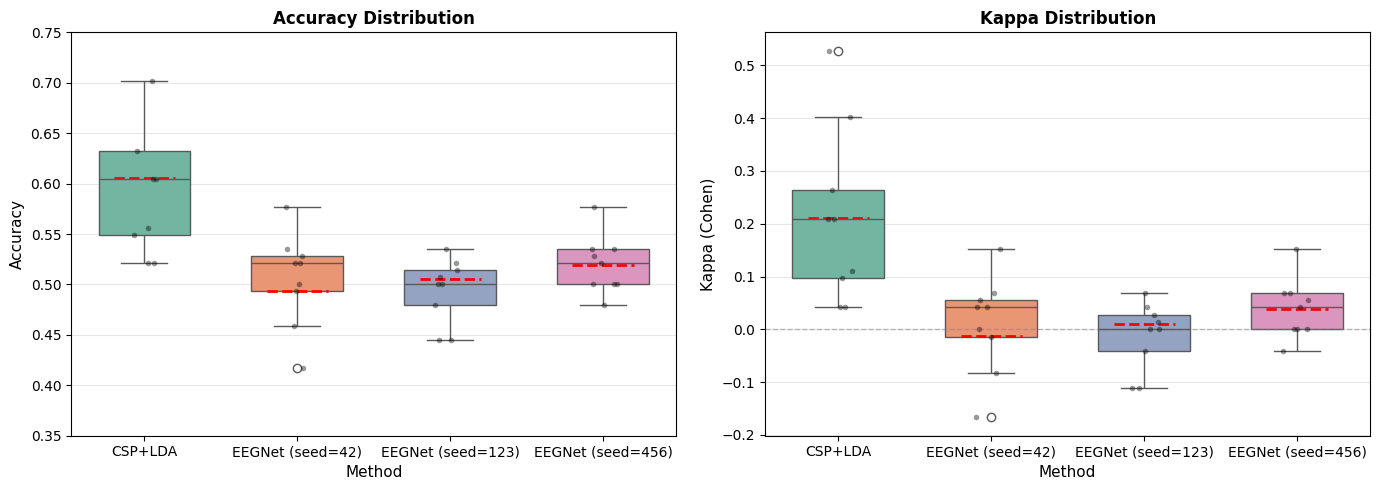

In [24]:
# ============================================================================
# 14) FIGURA 3: Boxplot + Violin de Accuracy e Kappa
# ============================================================================
import seaborn as sns

# Preparar dados para plot
plot_data = []

# CSP+LDA
for subject, result in results_csp_lda.items():
    plot_data.append({'Method': 'CSP+LDA', 'Subject': subject, 'Accuracy': result['acc'], 'Kappa': result['kappa']})

# EEGNet (agregado sobre todos os seeds)
for seed, results_seed in results_eegnet_all_seeds.items():
    for subject, result in results_seed.items():
        plot_data.append({'Method': f'EEGNet (seed={seed})', 'Subject': subject, 'Accuracy': result['acc'], 'Kappa': result['kappa']})

df_plot = pd.DataFrame(plot_data)

# Agregação simples para visualização
df_agg = []
for subject in sorted(results_csp_lda.keys()):
    # CSP
    acc_csp = results_csp_lda[subject]['acc']
    kappa_csp = results_csp_lda[subject]['kappa']
    df_agg.append({'Method': 'CSP+LDA', 'Subject': f'S{subject}', 'Accuracy': acc_csp, 'Kappa': kappa_csp, 'Type': 'Accuracy'})
    df_agg.append({'Method': 'CSP+LDA', 'Subject': f'S{subject}', 'Accuracy': kappa_csp, 'Kappa': kappa_csp, 'Type': 'Kappa'})
    
    # EEGNet (média de seeds)
    accs_eeg = [results_eegnet_all_seeds[seed][subject]['acc'] for seed in EEGNET_SEEDS]
    kappas_eeg = [results_eegnet_all_seeds[seed][subject]['kappa'] for seed in EEGNET_SEEDS]
    acc_eeg_mean = np.mean(accs_eeg)
    kappa_eeg_mean = np.mean(kappas_eeg)
    
    df_agg.append({'Method': 'EEGNet', 'Subject': f'S{subject}', 'Accuracy': acc_eeg_mean, 'Kappa': kappa_eeg_mean, 'Type': 'Accuracy'})
    df_agg.append({'Method': 'EEGNet', 'Subject': f'S{subject}', 'Accuracy': kappa_eeg_mean, 'Kappa': kappa_eeg_mean, 'Type': 'Kappa'})

df_agg = pd.DataFrame(df_agg)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Accuracy ---
ax = axes[0]
sns.boxplot(data=df_plot, x='Method', y='Accuracy', ax=ax, palette='Set2', width=0.6)
sns.stripplot(data=df_plot, x='Method', y='Accuracy', ax=ax, color='black', alpha=0.4, size=4)
ax.set_title('Accuracy Distribution', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_xlabel('Method', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.35, 0.75])

# Adicionar linhas médias
for method_idx, method in enumerate(sorted(df_plot['Method'].unique())):
    data_method = df_plot[df_plot['Method'] == method]['Accuracy']
    mean_val = data_method.mean()
    ax.hlines(mean_val, method_idx-0.2, method_idx+0.2, colors='red', linewidth=2, linestyles='--', label='Mean' if method_idx == 0 else '')

# --- Kappa ---
ax = axes[1]
# Prepare kappa data
df_kappa = pd.DataFrame()
kappa_data = []
for subject, result in results_csp_lda.items():
    kappa_data.append({'Method': 'CSP+LDA', 'Kappa': result['kappa']})
for seed, results_seed in results_eegnet_all_seeds.items():
    for subject, result in results_seed.items():
        kappa_data.append({'Method': f'EEGNet (seed={seed})', 'Kappa': result['kappa']})
df_kappa = pd.DataFrame(kappa_data)

sns.boxplot(data=df_kappa, x='Method', y='Kappa', ax=ax, palette='Set2', width=0.6)
sns.stripplot(data=df_kappa, x='Method', y='Kappa', ax=ax, color='black', alpha=0.4, size=4)
ax.set_title('Kappa Distribution', fontsize=12, fontweight='bold')
ax.set_ylabel('Kappa (Cohen)', fontsize=11)
ax.set_xlabel('Method', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Adicionar linhas médias
for method_idx, method in enumerate(sorted(df_kappa['Method'].unique())):
    data_method = df_kappa[df_kappa['Method'] == method]['Kappa']
    mean_val = data_method.mean()
    ax.hlines(mean_val, method_idx-0.2, method_idx+0.2, colors='red', linewidth=2, linestyles='--')

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'metrics_distribution.png', dpi=FIG_DPI, bbox_inches='tight')
    print("✓ Salvo: metrics_distribution.png")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


✓ Salvo: confusion_matrices.png


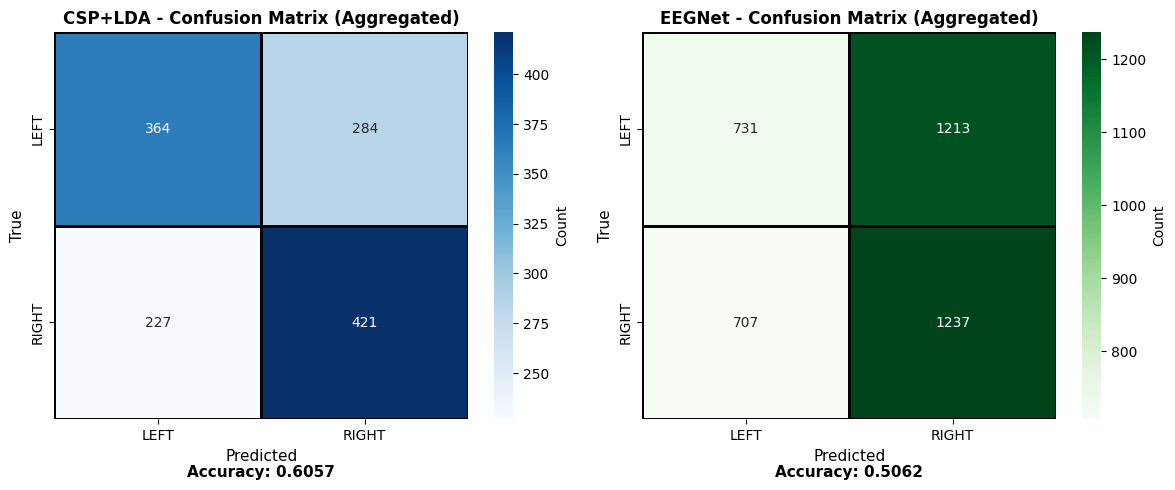


📊 Matrizes de Confusão Agregadas:
CSP+LDA:
[[364 284]
 [227 421]]
Accuracy: 0.6057

EEGNet:
[[ 731 1213]
 [ 707 1237]]
Accuracy: 0.5062


In [25]:
# ============================================================================
# 15) FIGURA 4: Matriz de Confusão Agregada
# ============================================================================

# Agregar todas as matrizes de confusão
cm_csp_total = np.zeros((2, 2), dtype=int)
cm_eeg_total = np.zeros((2, 2), dtype=int)

# CSP+LDA
for subject, result in results_csp_lda.items():
    cm_csp_total += result['confusion']

# EEGNet (agregado)
for seed, results_seed in results_eegnet_all_seeds.items():
    for subject, result in results_seed.items():
        cm_eeg_total += result['confusion']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- CSP+LDA ---
ax = axes[0]
sns.heatmap(cm_csp_total, annot=True, fmt='d', cmap='Blues', ax=ax, 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
ax.set_title('CSP+LDA - Confusion Matrix (Aggregated)', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('True', fontsize=11)
ax.set_xticklabels(['LEFT', 'RIGHT'])
ax.set_yticklabels(['LEFT', 'RIGHT'])

# Calcular acurácia
acc_csp_agg = (cm_csp_total[0,0] + cm_csp_total[1,1]) / cm_csp_total.sum()
ax.text(0.5, -0.15, f'Accuracy: {acc_csp_agg:.4f}', transform=ax.transAxes,
        ha='center', fontsize=11, fontweight='bold')

# --- EEGNet ---
ax = axes[1]
sns.heatmap(cm_eeg_total, annot=True, fmt='d', cmap='Greens', ax=ax,
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
ax.set_title('EEGNet - Confusion Matrix (Aggregated)', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('True', fontsize=11)
ax.set_xticklabels(['LEFT', 'RIGHT'])
ax.set_yticklabels(['LEFT', 'RIGHT'])

# Calcular acurácia
acc_eeg_agg = (cm_eeg_total[0,0] + cm_eeg_total[1,1]) / cm_eeg_total.sum()
ax.text(0.5, -0.15, f'Accuracy: {acc_eeg_agg:.4f}', transform=ax.transAxes,
        ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'confusion_matrices.png', dpi=FIG_DPI, bbox_inches='tight')
    print("✓ Salvo: confusion_matrices.png")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"\n📊 Matrizes de Confusão Agregadas:")
print(f"CSP+LDA:\n{cm_csp_total}\nAccuracy: {acc_csp_agg:.4f}")
print(f"\nEEGNet:\n{cm_eeg_total}\nAccuracy: {acc_eeg_agg:.4f}")



TABELA 1: Setup Experimental
       Parâmetro                          Valor
         Dataset                      BCICIV 2a
        Subjects                              9
         Classes                2 (LEFT, RIGHT)
   Sampling Rate                         250 Hz
     Filter Band                        8-30 Hz
    Filter Order                              4
  Trial Duration              4s (201 amostras)
    Total Trials 1296 (9 subjects × 144 trials)
Train/Test Split   Leave-One-Subject-Out (LOSO)
Cross-validation        9 folds (1 por sujeito)
✓ Salvo: tabela_setup_experimental.csv
✓ Salvo: tabela_setup.png


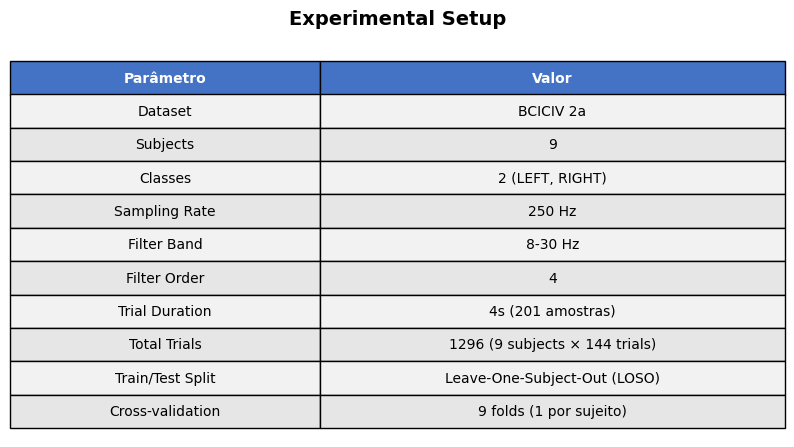

In [28]:
# ============================================================================
# 16) TABELA 1: Setup Experimental
# ============================================================================

setup_data = {
    'Parâmetro': [
        'Dataset',
        'Subjects',
        'Classes',
        'Sampling Rate',
        'Filter Band',
        'Filter Order',
        'Trial Duration',
        'Total Trials',
        'Train/Test Split',
        'Cross-validation',
    ],
    'Valor': [
        'BCICIV 2a',
        f'{len(results_csp_lda)}',
        '2 (LEFT, RIGHT)',
        f'{SFREQ} Hz',
        f'{FILTER_LOW}-{FILTER_HIGH} Hz',
        f'{FILTER_ORDER}',
        '4s (201 amostras)',
        '1296 (9 subjects × 144 trials)',
        'Leave-One-Subject-Out (LOSO)',
        '9 folds (1 por sujeito)',
    ]
}

df_setup = pd.DataFrame(setup_data)

print("\n" + "="*70)
print("TABELA 1: Setup Experimental")
print("="*70)
print(df_setup.to_string(index=False))
print("="*70)

# Salvar como CSV
df_setup.to_csv('tabela_setup_experimental.csv', index=False)
print("✓ Salvo: tabela_setup_experimental.csv")

# Visualizar como tabela formatada (HTML-style)
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_setup.values, colLabels=df_setup.columns,
                cellLoc='center', loc='center', 
                colWidths=[0.4, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilo da tabela
for i in range(len(df_setup.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(df_setup) + 1):
    for j in range(len(df_setup.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')

plt.title('Experimental Setup', fontsize=14, fontweight='bold', pad=20)
if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'tabela_setup.png', dpi=FIG_DPI, bbox_inches='tight')
    print("✓ Salvo: tabela_setup.png")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()



TABELA 2: Resultados por Sujeito
 Subject CSP Acc CSP Kappa EEGNet Acc (μ±σ) EEGNet Kappa (μ±σ)   Δ Acc Δ Kappa
       1  0.6319    0.2639    0.5278±0.0098      0.0556±0.0196 -0.1042 -0.2083
       2  0.5486    0.0972    0.5231±0.0033      0.0463±0.0065 -0.0255 -0.0509
       3  0.6042    0.2083    0.5000±0.0316      0.0000±0.0631 -0.1042 -0.2083
       4  0.5208    0.0417    0.5324±0.0322      0.0648±0.0645 +0.0116 +0.0231
       5  0.5208    0.0417    0.5255±0.0360      0.0509±0.0720 +0.0046 +0.0093
       6  0.5556    0.1111    0.4653±0.0354     -0.0694±0.0708 -0.0903 -0.1806
       7  0.6042    0.2083    0.5023±0.0236      0.0046±0.0472 -0.1019 -0.2037
       8  0.7014    0.4028    0.4884±0.0322     -0.0231±0.0645 -0.2130 -0.4259
       9  0.7639    0.5278    0.4907±0.0346     -0.0185±0.0693 -0.2731 -0.5463
✓ Salvo: tabela_resultados_por_sujeito.csv
✓ Salvo: tabela_resultados_sujeito.png


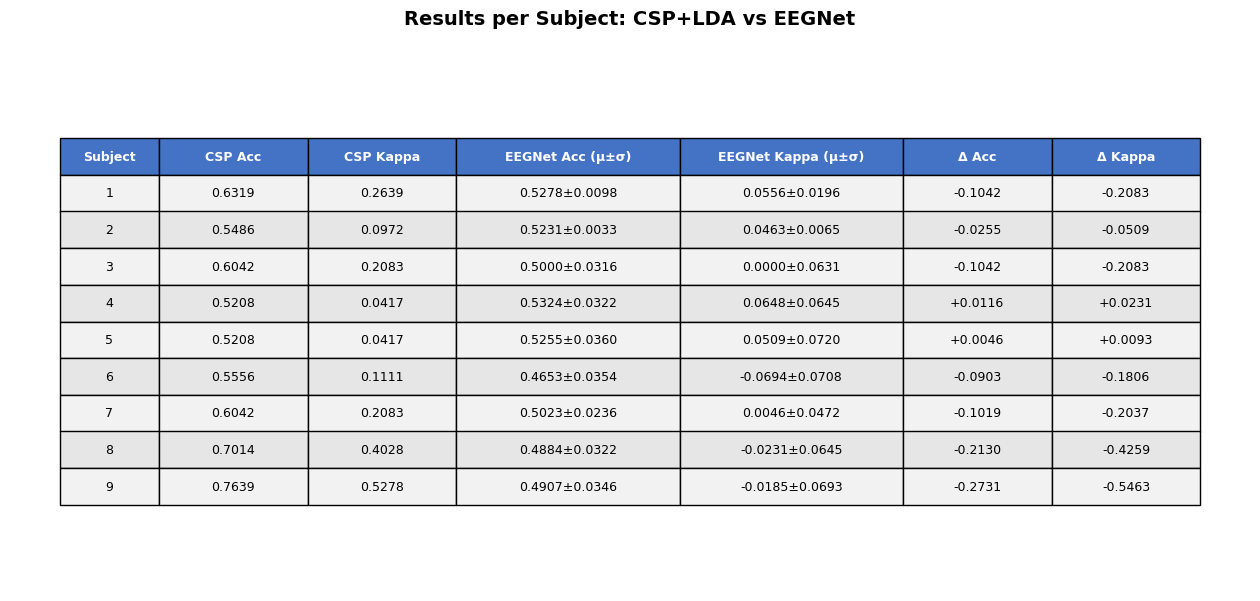

In [29]:
# ============================================================================
# 17) TABELA 2: Resultados por Sujeito (CSP+LDA vs EEGNet)
# ============================================================================

# Preparar dados agregados por sujeito
results_table = []

for subject in sorted(results_csp_lda.keys()):
    # CSP+LDA
    acc_csp = results_csp_lda[subject]['acc']
    kappa_csp = results_csp_lda[subject]['kappa']
    
    # EEGNet (média e std de seeds)
    accs_eeg = [results_eegnet_all_seeds[seed][subject]['acc'] for seed in EEGNET_SEEDS]
    kappas_eeg = [results_eegnet_all_seeds[seed][subject]['kappa'] for seed in EEGNET_SEEDS]
    
    acc_eeg_mean = np.mean(accs_eeg)
    acc_eeg_std = np.std(accs_eeg)
    kappa_eeg_mean = np.mean(kappas_eeg)
    kappa_eeg_std = np.std(kappas_eeg)
    
    results_table.append({
        'Subject': subject,
        'CSP Acc': f'{acc_csp:.4f}',
        'CSP Kappa': f'{kappa_csp:.4f}',
        'EEGNet Acc (μ±σ)': f'{acc_eeg_mean:.4f}±{acc_eeg_std:.4f}',
        'EEGNet Kappa (μ±σ)': f'{kappa_eeg_mean:.4f}±{kappa_eeg_std:.4f}',
        'Δ Acc': f'{acc_eeg_mean - acc_csp:+.4f}',
        'Δ Kappa': f'{kappa_eeg_mean - kappa_csp:+.4f}',
    })

df_results_table = pd.DataFrame(results_table)

print("\n" + "="*100)
print("TABELA 2: Resultados por Sujeito")
print("="*100)
print(df_results_table.to_string(index=False))
print("="*100)

# Salvar como CSV
df_results_table.to_csv('tabela_resultados_por_sujeito.csv', index=False)
print("✓ Salvo: tabela_resultados_por_sujeito.csv")

# Visualizar como tabela formatada
fig, ax = plt.subplots(figsize=(16, 7))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_results_table.values, colLabels=df_results_table.columns,
                cellLoc='center', loc='center',
                colWidths=[0.08, 0.12, 0.12, 0.18, 0.18, 0.12, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.2)

# Estilo
for i in range(len(df_results_table.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=9)

for i in range(1, len(df_results_table) + 1):
    for j in range(len(df_results_table.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')

plt.title('Results per Subject: CSP+LDA vs EEGNet', fontsize=14, fontweight='bold', pad=20)
if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'tabela_resultados_sujeito.png', dpi=FIG_DPI, bbox_inches='tight')
    print("✓ Salvo: tabela_resultados_sujeito.png")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()



TABELA 3: Resumo Estatístico (Média ± DP, Min, Max)
          Métrica   Mean    Std     Min    Max
   Accuracy (CSP) 0.6057 0.0782  0.5208 0.7639
Accuracy (EEGNet) 0.5062 0.0359  0.4167 0.5764
      Kappa (CSP) 0.2114 0.1564  0.0417 0.5278
   Kappa (EEGNet) 0.0123 0.0718 -0.1667 0.1528

📊 TESTES ESTATÍSTICOS (t-test, independente):
------------------------------------------------------------------------------------------
Accuracy: t=5.0318, p-value=0.000016
Kappa:    t=5.0318, p-value=0.000016
------------------------------------------------------------------------------------------
✓ Accuracies são significativamente diferentes (p < 0.05)
✓ Kappas são significativamente diferentes (p < 0.05)

✓ Salvo: tabela_resumo_estatistico.csv
✓ Salvo: tabela_resumo_estatistico.png


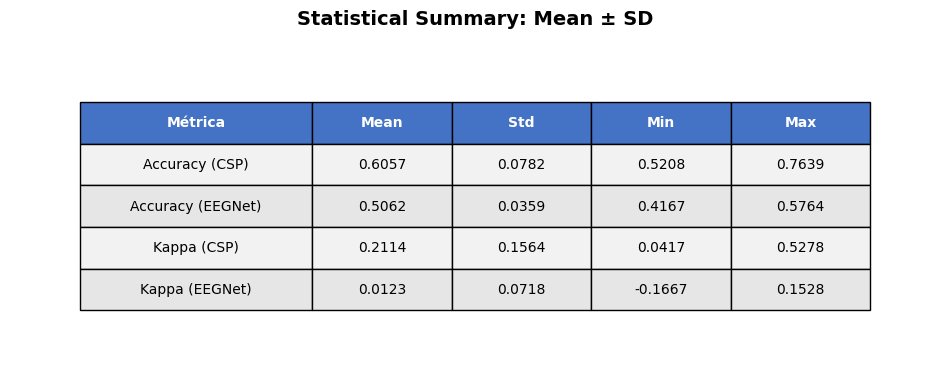

In [30]:
# ============================================================================
# 18) TABELA 3: Resumo Estatístico (Média ± DP)
# ============================================================================
from scipy import stats

# CSP+LDA stats
csp_accs = np.array([res['acc'] for res in results_csp_lda.values()])
csp_kappas = np.array([res['kappa'] for res in results_csp_lda.values()])

# EEGNet stats (agregado de todos os seeds)
eeg_accs_all = []
eeg_kappas_all = []
for seed, results_seed in results_eegnet_all_seeds.items():
    for subject, result in results_seed.items():
        eeg_accs_all.append(result['acc'])
        eeg_kappas_all.append(result['kappa'])

eeg_accs = np.array(eeg_accs_all)
eeg_kappas = np.array(eeg_kappas_all)

# Calcular estatísticas
def calc_stats(data):
    return {
        'Mean': np.mean(data),
        'Std': np.std(data),
        'Min': np.min(data),
        'Max': np.max(data),
        'Median': np.median(data),
    }

stats_csp_acc = calc_stats(csp_accs)
stats_csp_kappa = calc_stats(csp_kappas)
stats_eeg_acc = calc_stats(eeg_accs)
stats_eeg_kappa = calc_stats(eeg_kappas)

# Testes estatísticos
t_stat_acc, p_value_acc = stats.ttest_ind(csp_accs, eeg_accs)
t_stat_kappa, p_value_kappa = stats.ttest_ind(csp_kappas, eeg_kappas)

# Montar tabela
summary_data = {
    'Métrica': ['Accuracy (CSP)', 'Accuracy (EEGNet)', 'Kappa (CSP)', 'Kappa (EEGNet)'],
    'Mean': [
        f'{stats_csp_acc["Mean"]:.4f}',
        f'{stats_eeg_acc["Mean"]:.4f}',
        f'{stats_csp_kappa["Mean"]:.4f}',
        f'{stats_eeg_kappa["Mean"]:.4f}',
    ],
    'Std': [
        f'{stats_csp_acc["Std"]:.4f}',
        f'{stats_eeg_acc["Std"]:.4f}',
        f'{stats_csp_kappa["Std"]:.4f}',
        f'{stats_eeg_kappa["Std"]:.4f}',
    ],
    'Min': [
        f'{stats_csp_acc["Min"]:.4f}',
        f'{stats_eeg_acc["Min"]:.4f}',
        f'{stats_csp_kappa["Min"]:.4f}',
        f'{stats_eeg_kappa["Min"]:.4f}',
    ],
    'Max': [
        f'{stats_csp_acc["Max"]:.4f}',
        f'{stats_eeg_acc["Max"]:.4f}',
        f'{stats_csp_kappa["Max"]:.4f}',
        f'{stats_eeg_kappa["Max"]:.4f}',
    ],
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*90)
print("TABELA 3: Resumo Estatístico (Média ± DP, Min, Max)")
print("="*90)
print(df_summary.to_string(index=False))
print("="*90)

# Testes estatísticos
print("\n📊 TESTES ESTATÍSTICOS (t-test, independente):")
print("-" * 90)
print(f"Accuracy: t={t_stat_acc:.4f}, p-value={p_value_acc:.6f}")
print(f"Kappa:    t={t_stat_kappa:.4f}, p-value={p_value_kappa:.6f}")
print("-" * 90)

if p_value_acc < 0.05:
    print(f"✓ Accuracies são significativamente diferentes (p < 0.05)")
else:
    print(f"✗ Accuracies NÃO são significativamente diferentes (p >= 0.05)")

if p_value_kappa < 0.05:
    print(f"✓ Kappas são significativamente diferentes (p < 0.05)")
else:
    print(f"✗ Kappas NÃO são significativamente diferentes (p >= 0.05)")

# Salvar como CSV
df_summary.to_csv('tabela_resumo_estatistico.csv', index=False)
print("\n✓ Salvo: tabela_resumo_estatistico.csv")

# Visualizar como tabela formatada
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_summary.values, colLabels=df_summary.columns,
                cellLoc='center', loc='center',
                colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Estilo
for i in range(len(df_summary.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(df_summary) + 1):
    for j in range(len(df_summary.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')

plt.title('Statistical Summary: Mean ± SD', fontsize=14, fontweight='bold', pad=20)
if SAVE_FIGURES:
    plt.savefig(FIGURES_DIR / 'tabela_resumo_estatistico.png', dpi=FIG_DPI, bbox_inches='tight')
    print("✓ Salvo: tabela_resumo_estatistico.png")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


In [31]:
# ============================================================================
# 19) Resumo Final - Todas as figuras e tabelas salvas
# ============================================================================

print("\n" + "="*80)
print("FASE 7: FIGURAS E TABELAS FINAIS — COMPLETO")
print("="*80)

print("\n📊 FIGURAS GERADAS:")
print("-" * 80)
figures_list = [
    "pipeline_comparison.png - Comparação de pipelines CSP+LDA vs EEGNet",
    "eegnet_architecture.png - Arquitetura detalhada do EEGNet",
    "metrics_distribution.png - Boxplot de Accuracy e Kappa",
    "confusion_matrices.png - Matrizes de confusão agregadas",
    "tabela_setup.png - Tabela de setup experimental",
    "tabela_resultados_sujeito.png - Resultados por sujeito",
    "tabela_resumo_estatistico.png - Resumo estatístico (média ± dp)",
]

for fig in figures_list:
    print(f"  ✓ {fig}")

print("\n📋 TABELAS GERADAS (CSV):")
print("-" * 80)
tables_list = [
    "tabela_setup_experimental.csv - Setup do experimento",
    "tabela_resultados_por_sujeito.csv - Resultados por sujeito (CSP vs EEGNet)",
    "tabela_resumo_estatistico.csv - Resumo estatístico",
    "resultados_csp_lda.csv - Resultados CSP+LDA baseline",
    "resultados_eegnet_por_seed.csv - Resultados EEGNet por seed",
    "resultados_eegnet_detalhado.csv - Resultados EEGNet detalhados (sujeito × seed)",
]

for table in tables_list:
    print(f"  ✓ {table}")

print("\n" + "="*80)
print("LOCAL: " + str(FIGURES_DIR.resolve()))
print("="*80)

print("\n✅ TODAS AS FIGURAS E TABELAS FORAM SALVAS COM SUCESSO!")
print("\n💡 Dica: Use as figuras em `{}/` para seu artigo".format(FIGURES_DIR))
print("💡 Use os CSVs para análises adicionais ou relatórios\n")



FASE 7: FIGURAS E TABELAS FINAIS — COMPLETO

📊 FIGURAS GERADAS:
--------------------------------------------------------------------------------
  ✓ pipeline_comparison.png - Comparação de pipelines CSP+LDA vs EEGNet
  ✓ eegnet_architecture.png - Arquitetura detalhada do EEGNet
  ✓ metrics_distribution.png - Boxplot de Accuracy e Kappa
  ✓ confusion_matrices.png - Matrizes de confusão agregadas
  ✓ tabela_setup.png - Tabela de setup experimental
  ✓ tabela_resultados_sujeito.png - Resultados por sujeito
  ✓ tabela_resumo_estatistico.png - Resumo estatístico (média ± dp)

📋 TABELAS GERADAS (CSV):
--------------------------------------------------------------------------------
  ✓ tabela_setup_experimental.csv - Setup do experimento
  ✓ tabela_resultados_por_sujeito.csv - Resultados por sujeito (CSP vs EEGNet)
  ✓ tabela_resumo_estatistico.csv - Resumo estatístico
  ✓ resultados_csp_lda.csv - Resultados CSP+LDA baseline
  ✓ resultados_eegnet_por_seed.csv - Resultados EEGNet por seed
  ✓